In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses
import os, random, numpy as np, tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

SEED = 42
os.environ["PYTHONHASHSEED"]=str(SEED)
os.environ["TF_DETERMINISTIC_OPS"]="1"
os.environ["TF_CUDNN_DETERMINISTIC"]="1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [77]:
CSV_PATH = './../data/AAPL_1h.csv'
DATE_COL = 'Datetime'

SEQ_LENGTH = 90
BATCH_SIZE = 32
LEARNING_RATE = 0.000001
EPOCHS = 100
TEST_RATIO = 0.2
VAL_SPLIT = 0.1

FEATURES = [
    # Price and Volume Data (Best with Standard Scaling)
    ('Close', 'standard'),
    ('High', 'standard'),
    ('Low', 'standard'),
    ('Open', 'standard'),
    ('Volume', 'standard'),
    ('log_returns', 'standard'),

    # Momentum, Trend & Volatility Indicators (Best with Standard Scaling)
    ('macd', 'standard'),
    ('roc', 'standard'),
    ('adx', 'standard'),
    ('di_plus', 'standard'),
    ('di_minus', 'standard'),
    ('atr_14', 'standard'),
    ('atr_20', 'standard'),
    ('atr_5', 'standard'),
    ('volume_zscore_50', 'standard'),
    
    # Moving Averages & Bands (Best with Standard Scaling)
    ('ema_10', 'standard'),
    ('ema_20', 'standard'),
    ('ema_50', 'standard'),
    ('ema_100', 'standard'),
    ('ema_200', 'standard'),
    ('bb_lower_20', 'standard'),
    ('bb_middle_20', 'standard'),
    ('bb_upper_20', 'standard'),
    
    # Indicators that are Bounded or Ratios (Best with MinMax Scaling)
    ('rsi_14', 'minmax'),
    ('rsi_28', 'minmax'),
    ('rsi_50', 'minmax'),
    ('rsi_7', 'minmax'),
    ('stoch_k', 'minmax'),
    ('stoch_d', 'minmax'),
    ('close_pos', 'minmax'),         # Position of close within the bar
    ('body_range_ratio', 'minmax'),  # Candle body size vs. total range
    ('bb_width_20', 'minmax'),       # Bounded ratio: BB width as a fraction
    
    # Others
    ('obv', 'standard'),
    ('rolling_max_20', 'standard'),
    ('rolling_min_20', 'standard'),
    ('price_from_20d_high', 'standard'),
]

TARGET = 'next_close'



In [78]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])

In [79]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

STANDARD_FEATURES = [name for name, scaling in FEATURES if scaling == 'standard']
MINMAX_FEATURES = [name for name, scaling in FEATURES if scaling == 'minmax']

preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), STANDARD_FEATURES), 
        ('minmax_scale', MinMaxScaler(), MINMAX_FEATURES)
    ]
)

X_scaled = preprocessor.fit_transform(df[STANDARD_FEATURES + MINMAX_FEATURES])
N_FEATURES = X_scaled.shape[1]

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(df[['next_close']])

tmp_df = pd.DataFrame(X_scaled, columns=STANDARD_FEATURES + MINMAX_FEATURES)
print(tb.tabulate(tmp_df.describe().round(2), headers='keys', tablefmt='psql'))

+-------+---------+---------+---------+---------+----------+---------------+---------+---------+---------+-----------+------------+----------+----------+---------+--------------------+----------+----------+----------+-----------+-----------+---------------+----------------+---------------+---------+------------------+------------------+-----------------------+----------+----------+----------+---------+-----------+-----------+-------------+--------------------+---------------+
|       |   Close |    High |     Low |    Open |   Volume |   log_returns |    macd |     roc |     adx |   di_plus |   di_minus |   atr_14 |   atr_20 |   atr_5 |   volume_zscore_50 |   ema_10 |   ema_20 |   ema_50 |   ema_100 |   ema_200 |   bb_lower_20 |   bb_middle_20 |   bb_upper_20 |     obv |   rolling_max_20 |   rolling_min_20 |   price_from_20d_high |   rsi_14 |   rsi_28 |   rsi_50 |   rsi_7 |   stoch_k |   stoch_d |   close_pos |   body_range_ratio |   bb_width_20 |
|-------+---------+---------+---------

In [80]:
X, y = [], []
for i in range(len(X_scaled) - SEQ_LENGTH):
    X.append(X_scaled[i:(i + SEQ_LENGTH), :])
    y.append(y_scaled[i + SEQ_LENGTH - 1, 0]) 
    
X, y = np.array(X), np.array(y)

train_ratio = 1 - TEST_RATIO
train_size = int(len(X) * train_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}") # Should be (samples, 60, 34)
print(f"y_train shape: {y_train.shape}") # Should be (samples,) - a 1D array

X_train shape: (2557, 90, 36)
y_train shape: (2557,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(units=128, 
         return_sequences=True, 
         input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    
    LSTM(units=128, 
         return_sequences=False), 
    Dropout(0.3),
    
    Dense(units=64, activation='relu'),
    
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/home/michal/HDD/Univerity/WhiteRock/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 90, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,385 (876.50 KB)

 Trainable params: 224,385 (876.50 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
#monitors
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/100


2025-12-01 20:55:37.759666: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - loss: 0.1078 - val_loss: 0.0429
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 0.0921 - val_loss: 0.0502
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.0717 - val_loss: 0.0153
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 0.0823 - val_loss: 0.0916
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - loss: 0.1373 - val_loss: 0.0284
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - loss: 0.0899 - val_loss: 0.0550
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - loss: 0.1627 - val_loss: 0.1054
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - loss: 0.1521 - val_loss: 0.0403
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 0.1431 - val_loss: 0.1421
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 0.1828 - val_loss: 0.1092
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 0.1985 - val_loss: 0.1554
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 12

In [ ]:
#save model
SAVE_PATH = './../models/m2/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
model.save(SAVE_PATH + 'lstm_model.h5')
joblib.dump(preprocessor, SAVE_PATH + 'preprocessor.save')
joblib.dump(target_scaler, SAVE_PATH + 'target_scaler.save')

In [83]:
y_pred = model.predict(X_test)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Test MSE: 13.9896
Test MAE: 2.9808
Test R²: 0.9681


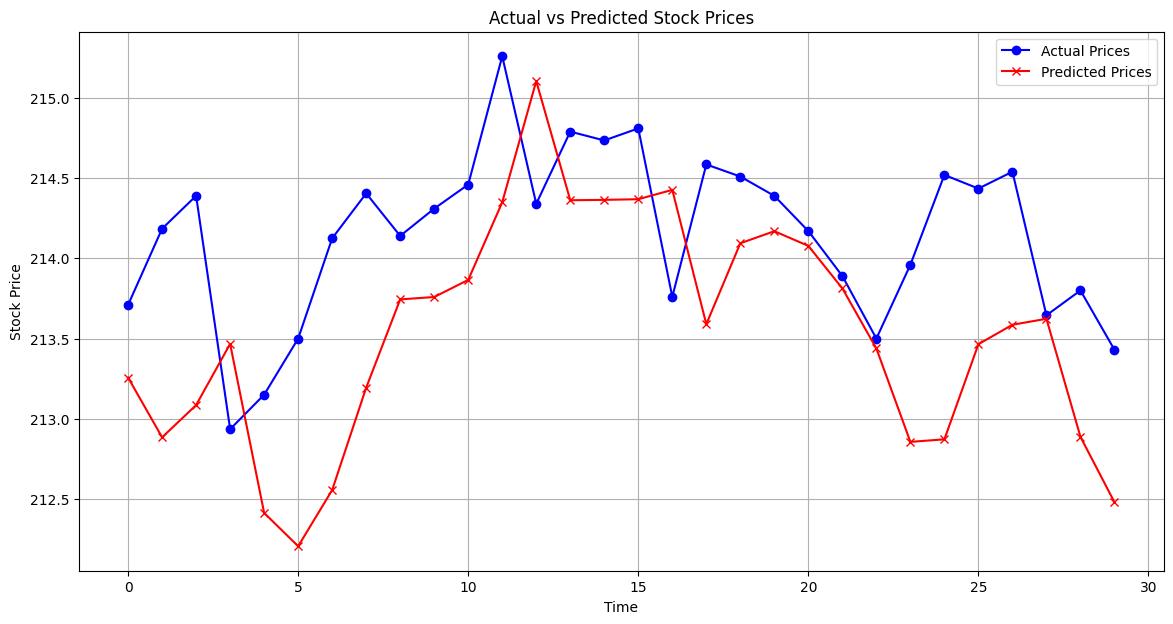

In [91]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv[:30], label='Actual Prices', color='blue', marker='o')
plt.plot(y_pred_inv[:30], label='Predicted Prices', color='red', marker='x')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [88]:
pred_df = pd.DataFrame({
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

print(tb.tabulate(pred_df.head(10).round(2), headers='keys', tablefmt='psql'))

+----+----------+-------------+
|    |   Actual |   Predicted |
|----+----------+-------------|
|  0 |   213.71 |      213.26 |
|  1 |   214.18 |      212.88 |
|  2 |   214.39 |      213.09 |
|  3 |   212.94 |      213.47 |
|  4 |   213.15 |      212.41 |
|  5 |   213.5  |      212.21 |
|  6 |   214.12 |      212.56 |
|  7 |   214.4  |      213.19 |
|  8 |   214.14 |      213.74 |
|  9 |   214.31 |      213.76 |
+----+----------+-------------+
